# Geoquery dataset, sql format, query based split

Yao Fu. University of Edinburgh<br>
yao.fu@ed.ac.uk<br>
Apr 30th 2021

In [1]:
import json
import sys

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from utils import print_sql_as_tree, sql_width_depth
from tqdm import tqdm
from pprint import pprint
from collections import Counter, defaultdict

In [2]:
data_path = '/Users/yaofu/Projects/semantic_parsing_datasets/text2sql-data/data'
data = json.load(open(data_path + '/geography.json'))

In [10]:
def test_contain_all_var(sent, varibles):
    all_in = True
    for v in varibles:
        if(v not in sent): all_in = False
    return all_in

def test_contain_all_var_w_sql(sent, sql, varibles):
    all_in = True
    for v in varibles:
        if(v not in sent): all_in = False
        if(v not in sql): all_in = False
    return all_in

## Caveat: change MIN MAX. Process this part
def process_min_max(sql_data):
    sql_data_ = []
    for s in sql_data:
        if('MIN' in s or 'MAX' in s or 'COUNT' in s or 'SUM(' in s): 
            s_ = s.replace('MIN(', 'MIN (').replace('MAX(', 'MAX (')\
                  .replace('COUNT(', 'COUNT (').replace('SUM(', 'SUM (')
            sql_data_.append(s_)
        else:
            sql_data_.append(s)
    return sql_data_

In [11]:
train_questions = [] 
dev_questions = []
test_questions = []
for d in data:
    sql = d['sql'][0]
    q = []
    for qi in d['sentences']:
        if(test_contain_all_var_w_sql(qi['text'], sql, qi['variables'])):
            q.append(qi['text'])
    if(d['query-split'] == 'train'): train_questions.append(q)
    elif(d['query-split'] == 'dev'): dev_questions.append(q)
    else: test_questions.append(q)

train_sql = process_min_max([d['sql'][0] for d in data if d['query-split'] == 'train'])
dev_sql = process_min_max([d['sql'][0] for d in data if d['query-split'] == 'dev'])
test_sql = process_min_max([d['sql'][0] for d in data if d['query-split'] == 'test'])

print(len(train_sql), len(dev_sql), len(test_sql))

158 38 50


In [12]:
def write_data_depth_width(data, questions, setname):
    depth, width = [], []
    
    for sql in data:
        d, w = sql_width_depth(sql)
        depth.append(d)
        width.append(w)
    max_d = max(depth)
    max_w = max(width)
    
    fds_depth = [open('geo_outputs_sql/%s_depth_%d.txt' % (setname, (i + 1)), 'w') for i in range(max_d)]
    fds_width = [open('geo_outputs_sql/%s_width_%d.txt' % (setname, (i + 1)), 'w') for i in range(max_w)]
    depth, width = [], []
    for sql, q in zip(data, questions):
        d, w = sql_width_depth(sql)
        
        for qi in q:
            fds_depth[d - 1].write(qi + '\n')
        print_sql_as_tree(sql, fds_depth[d - 1])
        fds_depth[d - 1].write('----------------\n')
        depth.append(d)

        for qi in q:
            fds_width[w - 1].write(qi + '\n')
        print_sql_as_tree(sql, fds_width[w - 1])
        fds_width[w - 1].write('----------------\n')
        width.append(w)
    depth = Counter(depth)
    width = Counter(width)
    return depth, width

In [13]:
train_depth, train_width = write_data_depth_width(train_sql, train_questions, 'train')
print(train_depth, train_width)

Counter({2: 60, 1: 53, 3: 31, 4: 11, 5: 2, 6: 1}) Counter({1: 154, 2: 4})


In [7]:
train_vocab = []
for s in train_sql:
    train_vocab.extend(s[:-2].split())
train_vocab = Counter(train_vocab)

test_vocab = []
for s in test_sql:
    test_vocab.extend(s[:-2].split())
test_vocab = Counter(test_vocab)

train_total_words = sum([c for s, c in train_vocab.most_common()])
test_total_words = sum([c for s, c in test_vocab.most_common()])

print(len(train_vocab), len(test_vocab), train_total_words, test_total_words)

139 111 4362 1310


In [8]:
train_vocab_cnt, train_vocab_str = [], []
for s, c in train_vocab.most_common(80):
    train_vocab_cnt.append(c)
    train_vocab_str.append(s)
train_vocab_cnt = np.array(train_vocab_cnt) / train_total_words
    
test_vocab_cnt, test_vocab_str = [], []
for s, c in test_vocab.most_common(80):
    test_vocab_cnt.append(c)
    test_vocab_str.append(s)
test_vocab_cnt = np.array(test_vocab_cnt) / test_total_words

vis_data = {'freq': np.concatenate([train_vocab_cnt, test_vocab_cnt]), 
        'label': pd.Categorical(train_vocab_str + test_vocab_str), 
        'split': pd.Categorical(['train'] * len(train_vocab_cnt) + ['test'] * len(test_vocab_cnt))}
vis_data = pd.DataFrame(vis_data)

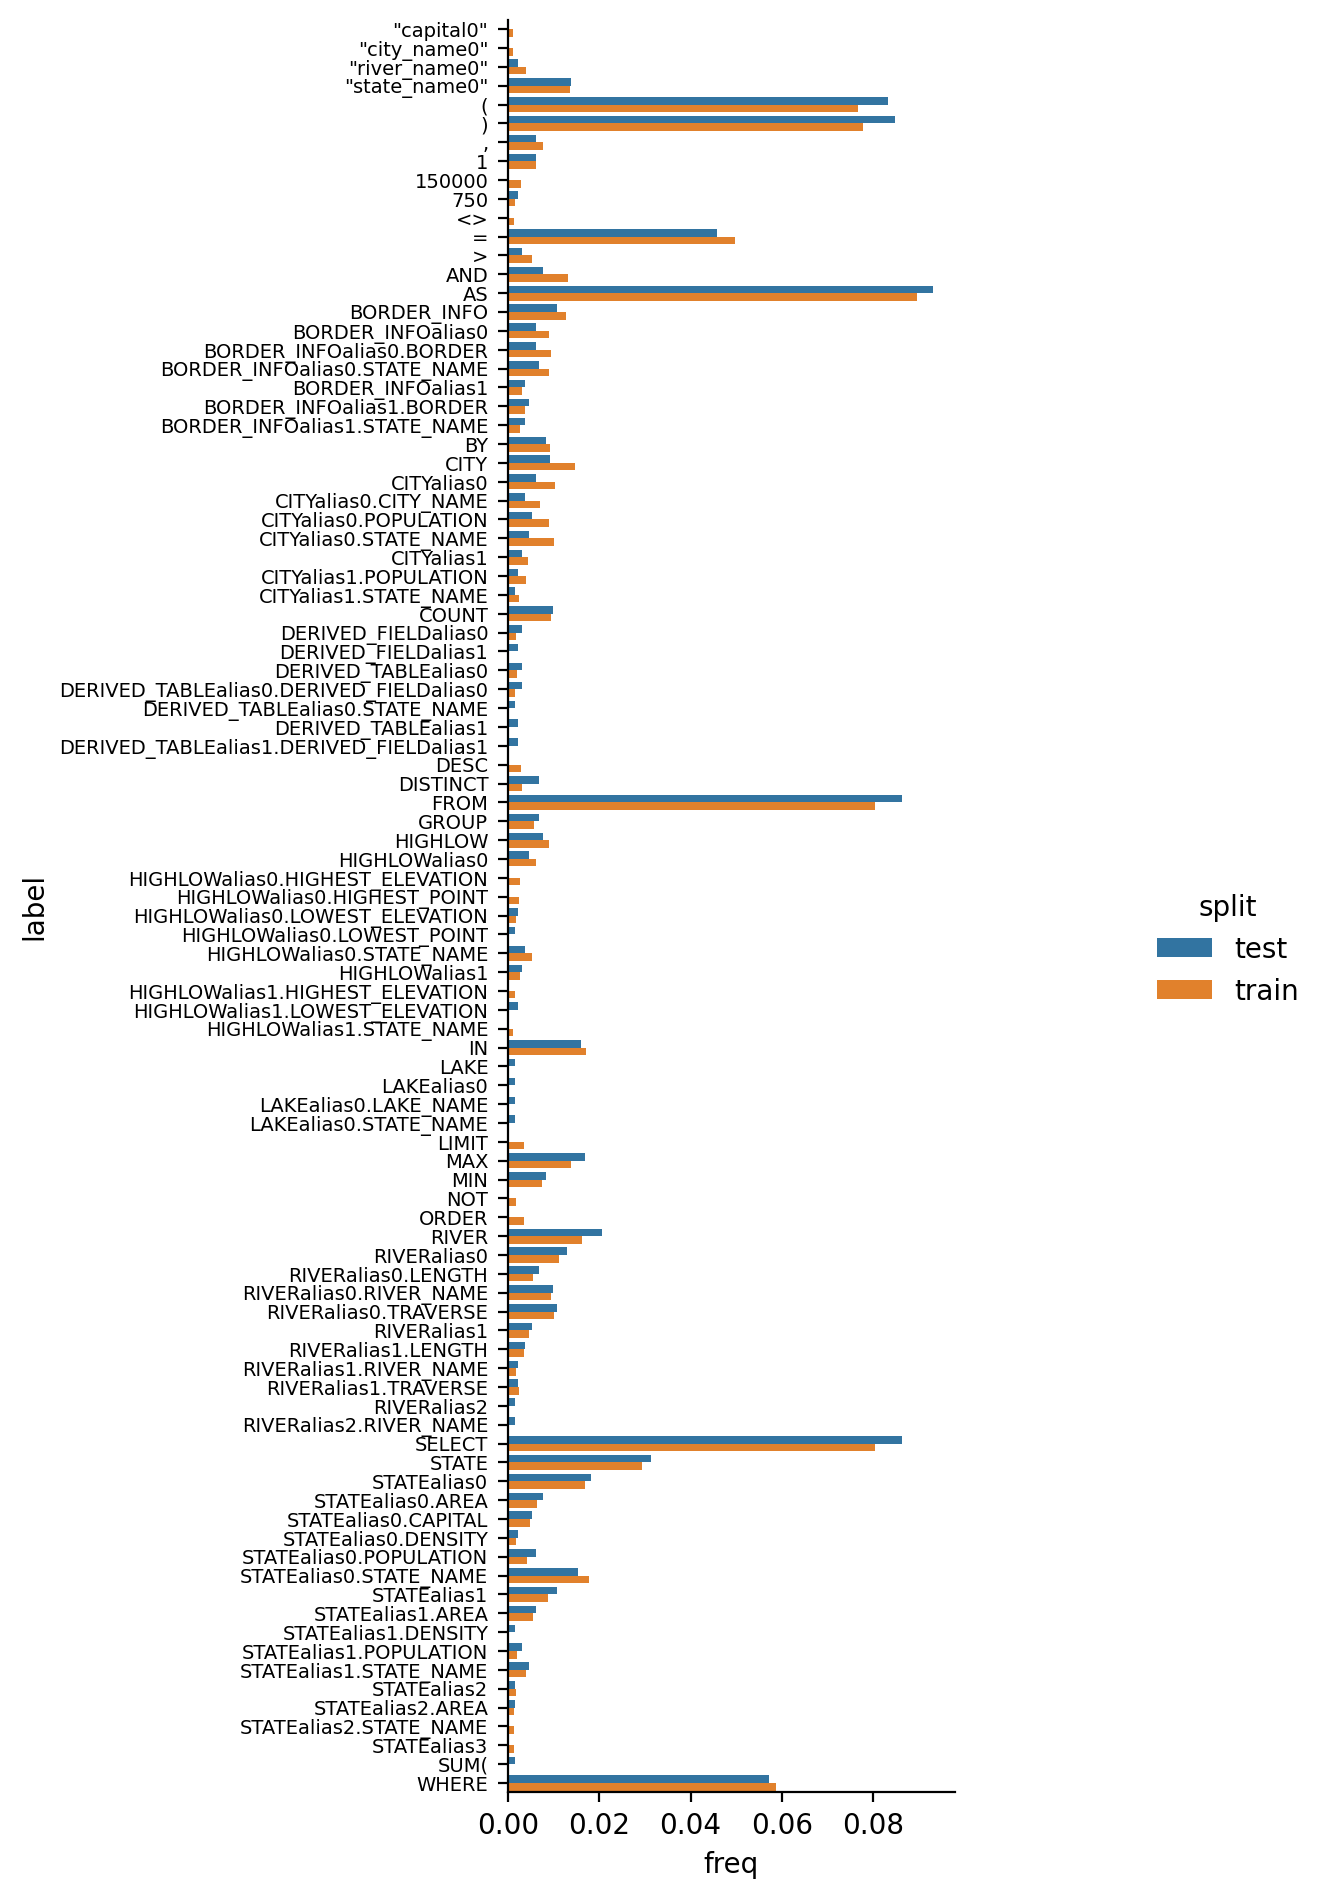

In [9]:
g = sns.catplot(data=vis_data, kind='bar', y='label', x='freq', hue='split', orient='h')
g.set_yticklabels(size = 7)
g.fig.set_size_inches([12, 10])
g.fig.set_dpi(200)